# Demo Notebook
This notebook is to demonstrate the different classes and functions in the ipp_library.py file found in this repository. 

In [17]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain

In [20]:
import logging
reward_function = 'mean'
if not os.path.exists('./figures/' + str(reward_function)): 
    os.makedirs('./figures/' + str(reward_function))
logging.basicConfig(filename = './figures/'+ reward_function + '/robot.log', level = logging.INFO)
logger = logging.getLogger('robot')
from ipp_library import *

In [21]:
%matplotlib inline
%load_ext autoreload
%aimport ipp_library
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Current environment in violation of boundary constraint. Regenerating!
Current environment in violation of boundary constraint. Regenerating!
Current environment in violation of boundary constraint. Regenerating!
Current environment in violation of boundary constraint. Regenerating!
Environment initialized with bounds X1: ( 0.0 , 10.0 )  X2:( 0.0 , 10.0 )
World max value 26.2124257123 at location [ 6.84210526  0.52631579]
[ 0 ] Current Location:   (9.85, 9.822530478272327, 0.9894736842105303)


 ipp_library.py:594: RuntimeWarning:divide by zero encountered in log
 ipp_library.py:594: RuntimeWarning:invalid value encountered in sqrt


few paths available!
few paths available!
Number of rollouts: 4414 	 Size of tree: 11158
Current predicted max and value: 	[[ 0.  0.]] 	0.0
None
None
[ 1 ] Current Location:   (8.3792719727637763, 9.527642245374091, 3.3394736842105304)


 ipp_library.py:594: RuntimeWarning:invalid value encountered in double_scalars
 ipp_library.py:594: RuntimeWarning:divide by zero encountered in double_scalars


few paths available!
Number of rollouts: 3497 	 Size of tree: 9924
Current predicted max and value: 	[ 10.  10.] 	5.5667593835
None
None
[ 2 ] Current Location:   (7.994002823499299, 8.077963769771646, 4.452631578947372)
Number of rollouts: 257 	 Size of tree: 1099
Current predicted max and value: 	[ 10.  10.] 	5.92615503636
None
None
[ 3 ] Current Location:   (7.7905223341005954, 6.5918292905154576, 4.5763157894736874)
Number of rollouts: 266 	 Size of tree: 1114
Current predicted max and value: 	[ 10.  10.] 	5.97059101929
None
None
[ 4 ] Current Location:   (6.2946493163525004, 6.4806361487610893, 3.2157894736842136)
Number of rollouts: 267 	 Size of tree: 1148
Current predicted max and value: 	[ 10.  10.] 	5.97318248213
None
None
[ 5 ] Current Location:   (5.1402838151529071, 5.5228051147889108, 3.8342105263157928)
Number of rollouts: 323 	 Size of tree: 1398
Current predicted max and value: 	[ 10.  10.] 	5.97356278813
None
None
[ 6 ] Current Location:   (3.6444107974048121, 5.41161

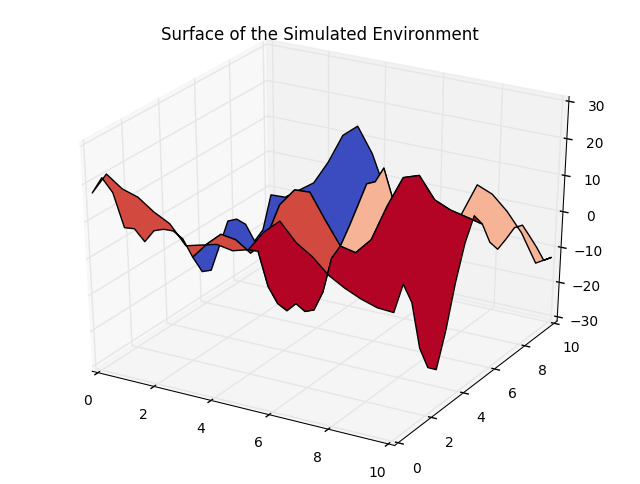

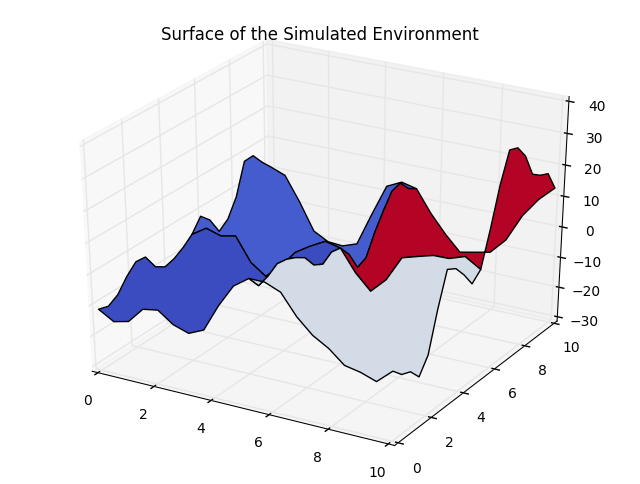

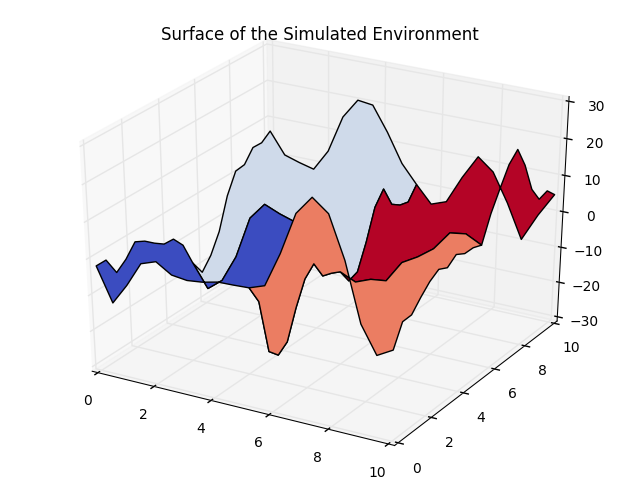

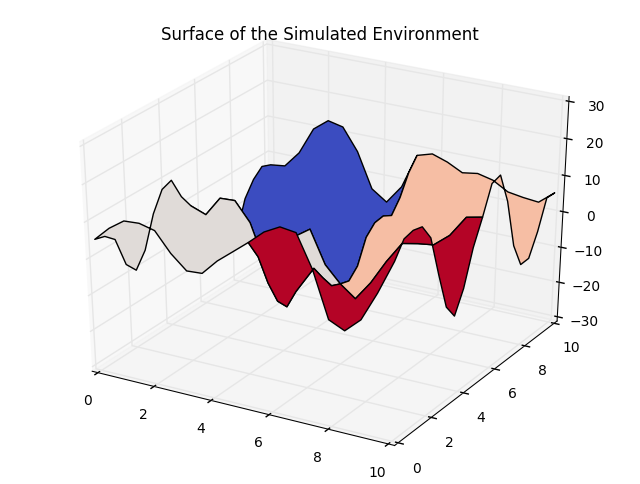

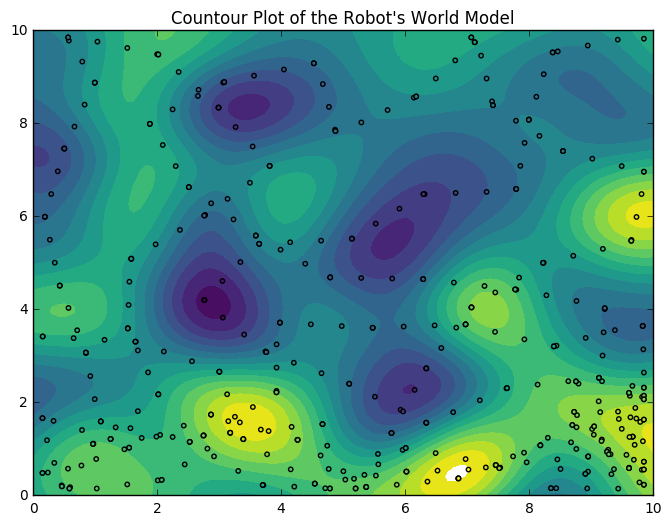

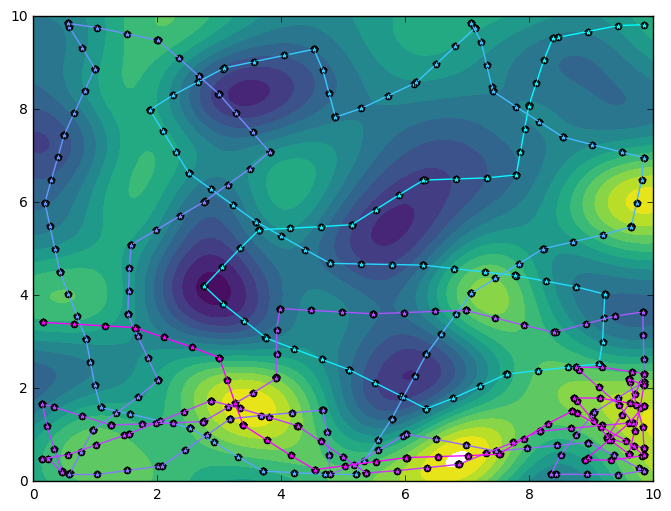

 ipp_library.py:1347: RuntimeWarning:invalid value encountered in divide
 ipp_library.py:1352: RuntimeWarning:invalid value encountered in divide


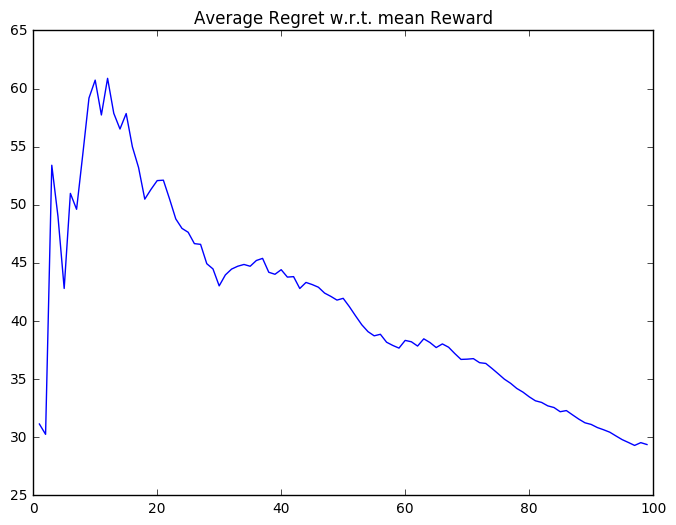

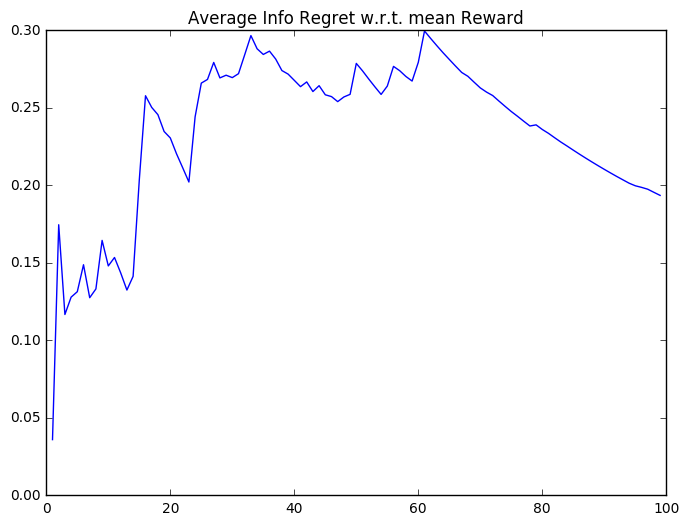

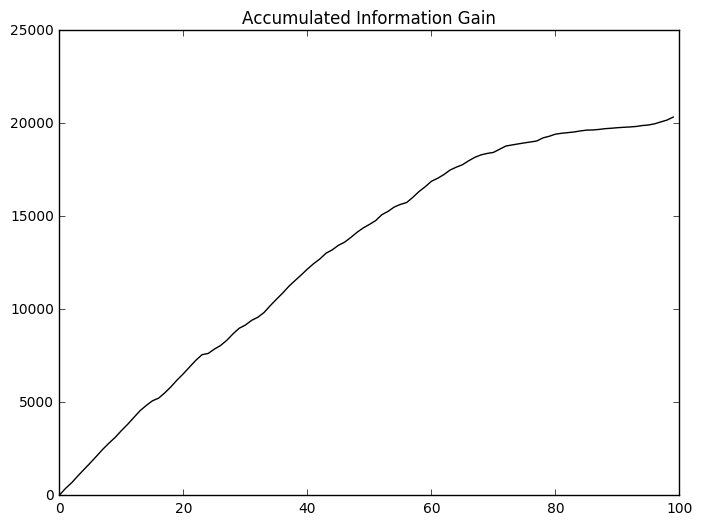

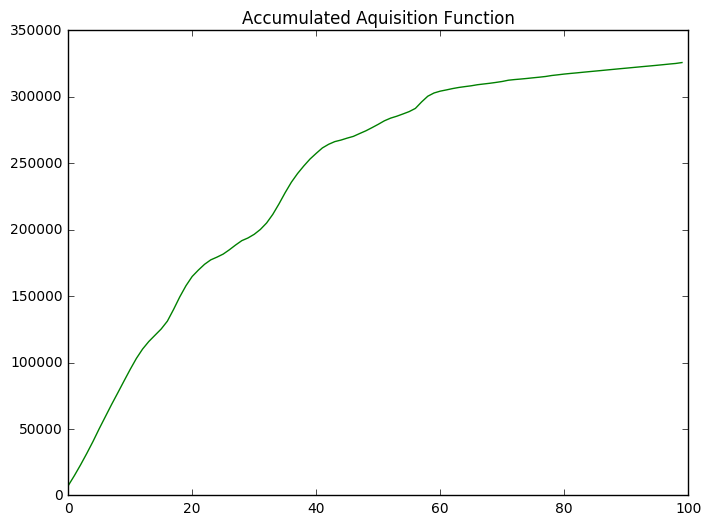

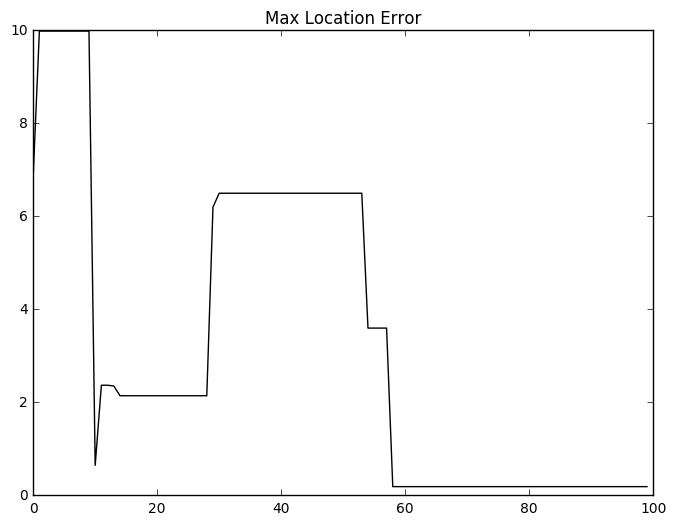

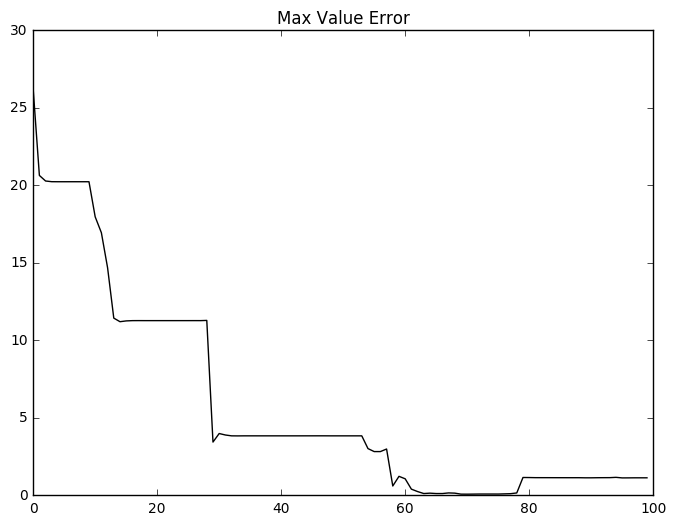

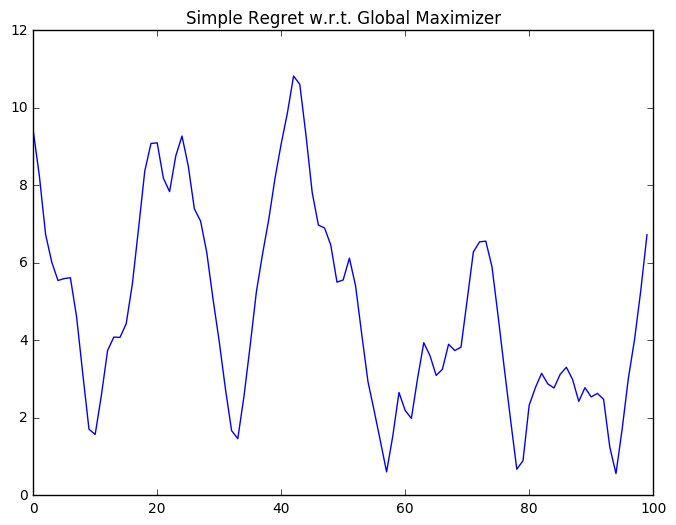

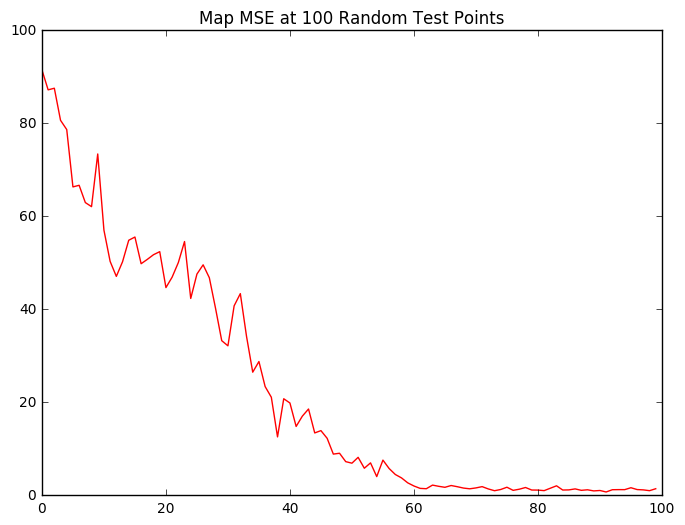

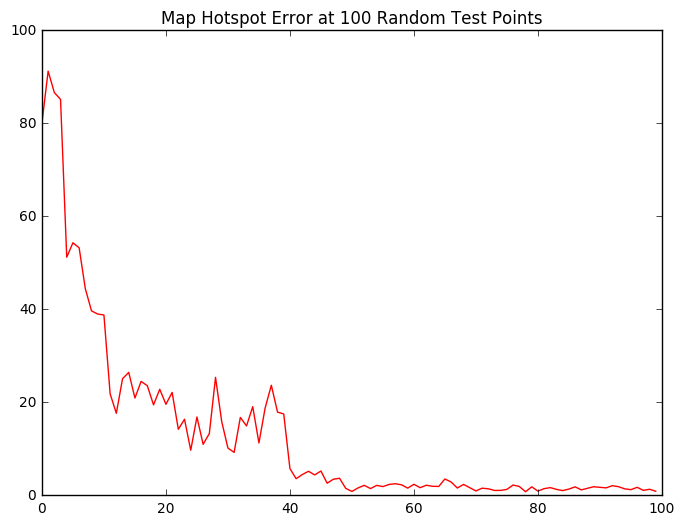

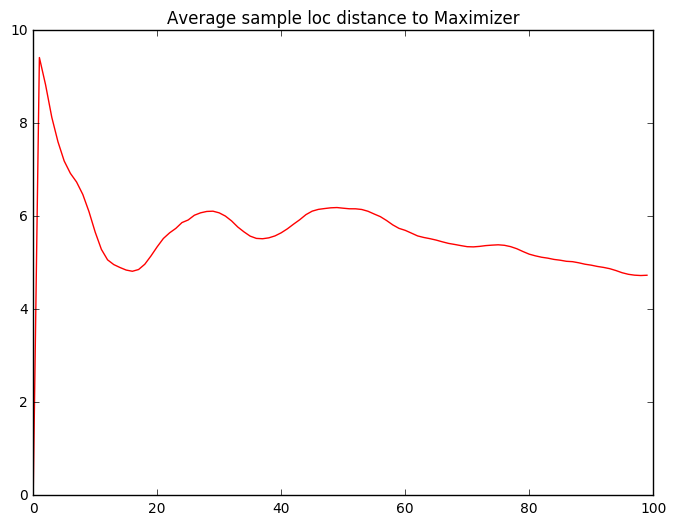

In [22]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 0)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
#x1observe = np.linspace(ranges[0]+0.5, ranges[1]-0,5, 15)
#x2observe = np.linspace(ranges[2]+0.5, ranges[3]-0.5, 15)
x1observe = np.linspace(0., 10., 20)
x2observe = np.linspace(0., 10., 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T

# TODO: make the edges less appealing!

observations = world.sample_value(data)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (9.85, 9.8225304782723271, 0.98947368421053028), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
#               prior_dataset =  (data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 1.5, 
              turning_radius = 0.05,
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 100)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()


In [ ]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, exp_improve and mes'''
reward_function = 'mes'
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 3)

evaluation = Evaluation(world = world, 
                        reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(ranges[0], ranges[1], 8)
x2observe = np.linspace(ranges[2], ranges[3], 8)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Robot(sample_world = world.sample_value, 
              start_loc = (5.0, 5.0, 0.0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              #prior_dataset =  None, 
              prior_dataset =  (data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 1.0, 
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True)

robot.planner(T = 150)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()

## [Link to trajectories and video](https://drive.google.com/drive/u/0/folders/1Xc5W2qg42H-HC5SGa_Gvvq0doq8sIaPp) for nonmyopic mes demo that gets stuck on the edge

In [ ]:
import io
import base64
from IPython.display import HTML


video = io.open('./figures/mes/output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
